In [1]:
from einops import rearrange,reduce,repeat

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

- https://einops.rocks/api/repeat/
- https://zhuanlan.zhihu.com/p/342675997
- https://mp.weixin.qq.com/s/9o5ZW-0-36MisCUwxZhs4Q

as for depth-space conversion:
- https://blog.csdn.net/qq_36556893/article/details/89471553
- https://stackoverflow.com/questions/44264962/how-tf-space-to-depth-works-in-tensorflow?rq=1

一个很棒的网站，展示了很多old方法用einops改写后的例子：
- http://einops.rocks/pytorch-examples.html

## 定义

In [35]:
ndarray = np.load('./test_images.npy',allow_pickle=False)
imgs = torch.from_numpy(ndarray).permute(0,3,1,2)
imgs.shape

torch.Size([6, 3, 96, 96])

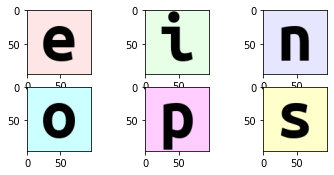

In [36]:
size = int(math.sqrt(imgs.shape[0]))+1
plt.figure()
for i in range (imgs.shape[0]):
    plt.subplot(size,size,i+1)
    plt.imshow(ndarray[i])
plt.show()

## 例子

### rearrange

In [37]:
# 转换维度，比如CHW -> HWC
rearrange(imgs,'b c h w -> b h w c').shape,imgs.permute(0,2,3,1).shape
                                    # numpy:transpose ~ torch:permute

(torch.Size([6, 96, 96, 3]), torch.Size([6, 96, 96, 3]))

In [44]:
# flatten
rearrange(imgs,'b c h w ->b (c h w)').shape, imgs.reshape(imgs.shape[0],-1).shape

(torch.Size([6, 27648]), torch.Size([6, 27648]))

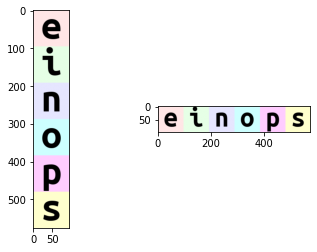

torch.Size([3, 576, 96]) torch.Size([3, 96, 576])


In [42]:
# concat batches *along* different axis
concat_height = rearrange(imgs,'b c h w -> c (b h) w')  # alone height-axis
concat_width  = rearrange(imgs,'b c h w -> c h (b w)')  # along width-axis

concats = [concat_height,concat_width]
plt.figure()
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(concats[i].numpy().transpose(1,2,0))
plt.show()
    
print(concat_height.shape,concat_width.shape)

**在这里每一个字母就是batch中的一张图片!**<br>
从矩阵坐标系易懂，height~axis0，即“沿着row方向”。所以**我上面的结果是正确的！**

我因为是基于torch tensor作为例子的，所以上面concat的例子中写为了'bchw'<br>
而在官方例子(https://einops.rocks/api/rearrange/ )中，则是基于ndarray作为例子。所以是'bhwc'。<br>
在这里，最终实现了和官方例子一样的效果(见：https://zhuanlan.zhihu.com/p/342675997 )！这说明我理解了concat的语法形式！<br>** nm为什么形式是这样，懂得这个形式代表concat即可！

注意，我一开始写作‘bcwh’，然后一切都旋转了，这说明w和h在einops中不只是”占位符“，而是和width和height一一对应的！ nm

In [46]:
# squeeze and unsqueeze
print(rearrange(imgs,'b c h w -> 1 b c h w').shape, imgs.unsqueeze(0).shape)
temp = imgs.unsqueeze(0)
print(rearrange(temp,'1 b c h w -> b c h w').shape, imgs.squeeze(0).shape)

torch.Size([1, 6, 3, 96, 96]) torch.Size([1, 6, 3, 96, 96])
torch.Size([6, 3, 96, 96]) torch.Size([6, 3, 96, 96])


In [89]:
# transpose + split
num=2
t1 = rearrange(imgs,'b c h (w w1) -> b c w1 h w',w1=num) # w*w1 ==> "w*w1=96"

print(t1.shape,imgs.view(imgs.shape[0],imgs.shape[1],imgs.shape[2],imgs.shape[3]//num,num).permute(0,1,4,2,3).shape)
# show = t1.numpy()[0,:,0,:,:].transpose(1,2,0)
# plt.figure()
# #plt.subplot(1,1,i+1)
# plt.imshow(show.transpose(1,2,0))
# plt.show()

# 'b c h (w w1) -> b c w1 h w'  ==> 先view(reshape),再permute(transpose)
# 看👆代码易懂。

torch.Size([6, 3, 2, 96, 48]) torch.Size([6, 3, 2, 96, 48])


### reduce

In [57]:
# mean/max
# -------------------------
# global average pooling
print(reduce(imgs,'b c h w -> b c','mean').shape)
# global max pooling
print(reduce(imgs,'b c h w -> b c () ()','max').shape)
# 加()后，起到占位符的作用，会存在1的dim。
# 为什么要占位，见👇紧接着的两个cell易懂。
# -------------------------

torch.Size([6, 3])
torch.Size([6, 3, 1, 1])


In [58]:
# Subtracting mean over batch for each channel
temp1 = reduce(imgs,'b c h w -> () c () ()','mean')
temp2 = reduce(imgs,'b c h w -> c','mean')
temp1.shape,temp2.shape
# 同理自己可以写出subtract mean for each hw plane

(torch.Size([1, 3, 1, 1]), torch.Size([3]))

In [55]:
(x - temp1).shape

torch.Size([5, 3, 32, 32])

In [56]:
(x-temp2).shape

RuntimeError: The size of tensor a (32) must match the size of tensor b (3) at non-singleton dimension 3

由此可知，如果不加占位符，那么得到结果就会是一个低维向量，<br>
在一些情况下会出现维度对不齐的情况，比如上面的temp2。**所以()是必须的**。<br>
** 也可以用 1 代替 ()

### repeat

In [59]:
image = np.random.randn(30, 40)

In [60]:
# 比如灰度图转三通道图
repeat(image, 'h w -> h w c', c=3).shape

(30, 40, 3)

In [61]:
# repeat 2x along height/width, e.g. height
repeat(image,'h w -> (repeat h) w',repeat=2).shape

(60, 40)

In [62]:
# repeat 2x along height/width, e.g. width
repeat(image,'h w -> h (repeat w)',repeat=2).shape

(30, 80)

## PyTorch

### torch & einops

见：https://mp.weixin.qq.com/s/9o5ZW-0-36MisCUwxZhs4Q 易懂，主要思路是把einops作为torch的layer！

### torch.einsum <br>
- https://pytorch.org/docs/stable/generated/torch.einsum.html?highlight=einsum
- **最好是看对应的OneNote笔记！**

In [91]:
src = torch.randn(3,3)
src

tensor([[-0.0584, -2.0269,  0.9480],
        [-2.5766, -1.5123, -1.5205],
        [ 0.1925,  0.5576, -2.1396]])

In [94]:
# trace
torch.einsum('ii', src)

tensor(-3.7103)

In [95]:
# diagonal
torch.einsum('ii->i', src)

tensor([-0.0584, -1.5123, -2.1396])

In [116]:
x = torch.randn(3)
y = torch.randn(3)
x,'\n',y

(tensor([ 1.4697, -1.7374,  1.2483]),
 '\n',
 tensor([-1.6772,  0.0747, -1.6694]))

In [117]:
# outer product
torch.einsum('i,j->ij', x, y)

tensor([[-2.4650,  0.1099, -2.4536],
        [ 2.9139, -0.1299,  2.9004],
        [-2.0936,  0.0933, -2.0839]])

In [120]:
# inner product
torch.einsum('i,i->',x,y)

tensor(-4.6787)

In [119]:
(x*y).sum()

tensor(-4.6787)